In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.cross_validation import train_test_split
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from skimage.feature import hog

%matplotlib inline

C:\Users\ymlai\Anaconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Feature extraction function

In [2]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def bin_spatial(img, size=(32, 32)):
    new_img = cv2.resize(img, size)
    # Use cv2.resize().ravel() to create the feature vector
    features = new_img.ravel() # Remove this line!
    # Return the feature vector
    return features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False,
                          visualise=True, feature_vector=False)
                          
        return features, hog_image
    else:      
        features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False,
                          visualise=False, feature_vector=feature_vec)
                          
        return features

## Draw box

In [3]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Searching for cars

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_helper(feature_image, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    file_features = []
    
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        _,_,_,_,hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
    
    return np.concatenate(file_features)
    
    
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)   
            
        features.append(extract_features_helper(feature_image, spatial_size, 
                                                hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                                spatial_feat, hist_feat, hog_feat))
        
        features.append(extract_features_helper(cv2.flip(feature_image, 1) , spatial_size, 
                                                hist_bins, orient, pix_per_cell, cell_per_block, hog_channel,
                                                spatial_feat, hist_feat, hog_feat))
        
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        _,_,_,_,hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))   
            hog_features = np.ravel(hog_features) 
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

## Train a Linear SVC for classification

In [8]:
# Read in cars and notcars
images = glob.glob('./vehicle_dataset/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

car_features = [x.astype(np.float64) for x in car_features]
notcar_features = [x.astype(np.float64) for x in notcar_features]

X = np.vstack((np.array(car_features), np.array(notcar_features))).astype(np.float64)          
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Car example: ', len(cars))
print('Non car example: ', len(notcars))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
Car example:  5966
Non car example:  8968


In [9]:
import sklearn.metrics

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
y_pred = svc.predict(X_test)

print('Test Accuracy of SVC = ', round(sklearn.metrics.accuracy_score(y_test, y_pred), 4))
# Check the prediction time for a single sample
t=time.time()

33.02 Seconds to train SVC...
Test Accuracy of SVC =  0.998


Number of incorrectly classified images: 12
Confusion matrix, without normalization


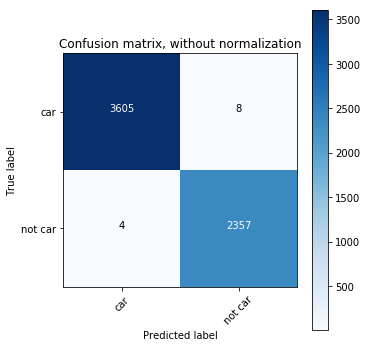

In [10]:
# Classification analysis
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
wrong_pred = X_test[y_test != y_pred]
print("Number of incorrectly classified images: %d" % len(wrong_pred))
cnf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['car', 'not car'], normalize=False,
                      title='Confusion matrix, without normalization')

## Searching for cars 2

In [11]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, hog_channel='ALL', 
              spatial_feat=True, hist_feat=True, hog_feat=True):
    
    draw_img = np.copy(img)
    
    img_tosearch = img[ystart:ystop,:,:]

    if color_space != 'RGB':
        if color_space == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(img)      
    
    img = img.astype(np.float32)/255
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat_list = [None, None, None]
            if hog_channel == 'ALL':
                hog_feat_list[0] = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat_list[1] = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat_list[2] = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat_list[0], hog_feat_list[1], hog_feat_list[2]))
            else:
                hog_features = hog_feature[hog_channel]

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            _,_,_,_,hist_features = color_hist(subimg, nbins=hist_bins)

            img_features = []
            if spatial_feat == True:
                img_features.append(spatial_features)
            if hist_feat == True:
                img_features.append(hist_features)
            if hog_feat == True:
                img_features.append(hog_features)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(img_features).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return draw_img, box_list

## Handling false postive

In [12]:
from scipy.ndimage.measurements import label

# Read in image similar to one shown above 
#image = mpimg.imread('./notebook_images/test_image.png')
image = mpimg.imread('./notebook_images/bbox-example-image.jpg')

heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list, bbox_list_w):
    # Iterate through list of bboxes
    for box, w in zip(bbox_list, bbox_list_w):
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += w

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [13]:
from PIL import Image

frame_cnt= 0
global_box_list = []
global_box_list_w = []

def pipeline(debug, img):
    global frame_cnt
    global global_box_list
    global global_box_list_w
    
    frame_cnt += 1
    scale = 1.5

    if len(global_box_list_w) > 0:
        global_box_list_w = [ x * 0.5 for x in global_box_list_w ]

        global_box_list = [global_box_list[i] for i in range(len(global_box_list_w)) if global_box_list_w[i] >= 0.1] 
        global_box_list_w = [global_box_list_w[i] for i in range(len(global_box_list_w)) if global_box_list_w[i] >= 0.1]
    
    out_img, box_list = find_cars(img, color_space, y_start_stop[0], y_start_stop[1], 
                                  scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, 
                                  spatial_size, hist_bins, hog_channel, 
                                  spatial_feat, hist_feat, hog_feat
                                 )
    
    
    global_box_list.extend(box_list)
    global_box_list_w.extend(np.repeat(1, len(box_list)))
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    heat = add_heat(heat, global_box_list, global_box_list_w)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    if debug:
        debug_im = Image.new('RGB', (image.shape[1] * 3 // 2, image.shape[0]))
        cv2.putText(draw_img, "Frame: %d" % frame_cnt, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2,
                    cv2.LINE_AA)
        debug_im.paste(Image.fromarray(draw_img), (0, 0))
        debug_im.paste(Image.fromarray(cv2.resize(out_img, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)),
                (image.shape[1], 0))
        heatmap = cv2.merge([heatmap/np.max(heatmap)*255, np.zeros_like(heatmap), np.zeros_like(heatmap)]).astype(np.uint8)
        debug_im.paste(Image.fromarray(cv2.resize(heatmap, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)),
                (image.shape[1],  image.shape[0] // 2))
        
        return np.array(debug_im)
    else:
        return draw_img

## Vehicle detection pipeline on image

In [14]:
import os

t_images = glob.glob('./test_images/*.*')

for i, fname in enumerate(t_images):    
    image = mpimg.imread(fname)
    image = image[:,:,0:3]
    frame_cnt= 0
    global_box_list = []
    global_box_list_w = []

    draw_img = pipeline(True, image)
    plt.imsave(os.path.join('./output_images', os.path.basename(fname)), draw_img)

## Vehicle detection pipeline on video

In [15]:
def process_image(debug, image):

    draw_img = pipeline(debug, image)

    return draw_img

In [16]:
from functools import partial

clip1 = VideoFileClip("test_video.mp4")
clip1_output = "test_video_output.mp4"

frame_cnt = 0
global_box_list = []
global_box_list_w = []
    
test_clip = clip1.fl_image(partial(process_image, True) ) 
%time test_clip.write_videofile(clip1_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:19<00:00,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 20 s


In [17]:
clip2 = VideoFileClip("project_video.mp4")
clip2_output = "project_video_output.mp4"

project_clip = clip2.fl_image(partial(process_image, True)) 
%time project_clip.write_videofile(clip2_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [11:07<00:00,  1.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 11min 8s


## Saving SVM

## testing svm

In [ ]:
test_img = plt.imread('vehicle_dataset/1000.jpeg')
plt.imshow(test_img)

car_features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
print(svc.predict(X_scaler.transform(np.array(car_features).reshape(1, -1))))

In [ ]:
# Test - incorrect case
test_img = plt.imread('vehicle_dataset/image1605.jpeg')
plt.imshow(test_img)

not_car_features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
print(svc.predict(X_scaler.transform(np.array(not_car_features).reshape(1, -1))))

In [ ]:
test_img = plt.imread('test_images/test1.jpg')
#1043 373 => 1187 517
test_img = cv2.resize(image[373:517, 1043:1187], (64, 64))  
plt.imshow(test_img)

car_features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
print(svc.predict(X_scaler.transform(np.array(car_features).reshape(1, -1))))

In [ ]:
test_img = cv2.resize(image[500:644, 503:647], (64, 64))  
plt.imshow(test_img)

car_features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
print(svc.predict(X_scaler.transform(np.array(car_features).reshape(1, -1))))